In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import pandas as pd
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

from metadata import df, df_meta
from data_loader import SoundDS
from CNN1 import AudioClassifier
from audio_utilities import AudioUtil
from GPU_CHOOSE import device

#set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

MPS available: True
Using device: mps


In [2]:
print("\n" + "=" * 50)
print("Data Prep")
print("=" * 50)

download_path = Path('/Users/lucasarnaiz/Desktop/p-ai/audioMNIST')

# download_path = Path.cwd() / 'audioMNIST'

print(f"Data path: {download_path}")
print(f"Path exists: {download_path.exists()}")

# Build audio paths dataframe, as a list containing dictionaries with two key-item pairs: speaker id and the relative file path
audio_paths = []
for folder in sorted(download_path.iterdir()):
    if folder.is_dir() and folder.name.isdigit():
        speaker_id = folder.name
        for wav_file in folder.glob('*.wav'):
            audio_paths.append({
                'speaker_id': speaker_id,
                'relative_path': str(wav_file.relative_to(download_path))
            })

df = pd.DataFrame(audio_paths) #use panda to convert our list into a dataframe
df['classID'] = df['speaker_id'].astype(int) - 1  # Convert 01-60 to 0-59, and store those values under a new column "classID"

print(f"Total audio files: {len(df)}")
print(f"Number of speakers: {df['speaker_id'].nunique()}")
print(f"Files per speaker: {len(df) // df['speaker_id'].nunique()}")
print(f"Class ID range: {df['classID'].min()} to {df['classID'].max()}")


Data Prep
Data path: /Users/lucasarnaiz/Desktop/p-ai/audioMNIST
Path exists: True
Total audio files: 30000
Number of speakers: 60
Files per speaker: 500
Class ID range: 0 to 59



METADATA ANALYSIS

Metadata Summary:
  speaker_id          accent age gender native speaker  \
0         01          german  30   male             no   
1         02          German  25   male             no   
2         03          German  31   male             no   
3         04          German  23   male             no   
4         05          German  25   male             no   
5         06          German  25   male             no   
6         07  German/Spanish  27   male             no   
7         08          German  41   male             no   
8         09    South Korean  35   male             no   
9         10          German  36   male             no   

                          origin      recordingdate recordingroom  
0     Europe, Germany, Wuerzburg  17-06-22-11-04-28          Kino  
1       Europe, Germany, Hamburg  17-06-26-17-57-29          Kino  
2        Europe, Germany, Bremen  17-06-30-17-34-51          Kino  
3     Europe, Germany, Helmstedt  17-06-30-18-09-14

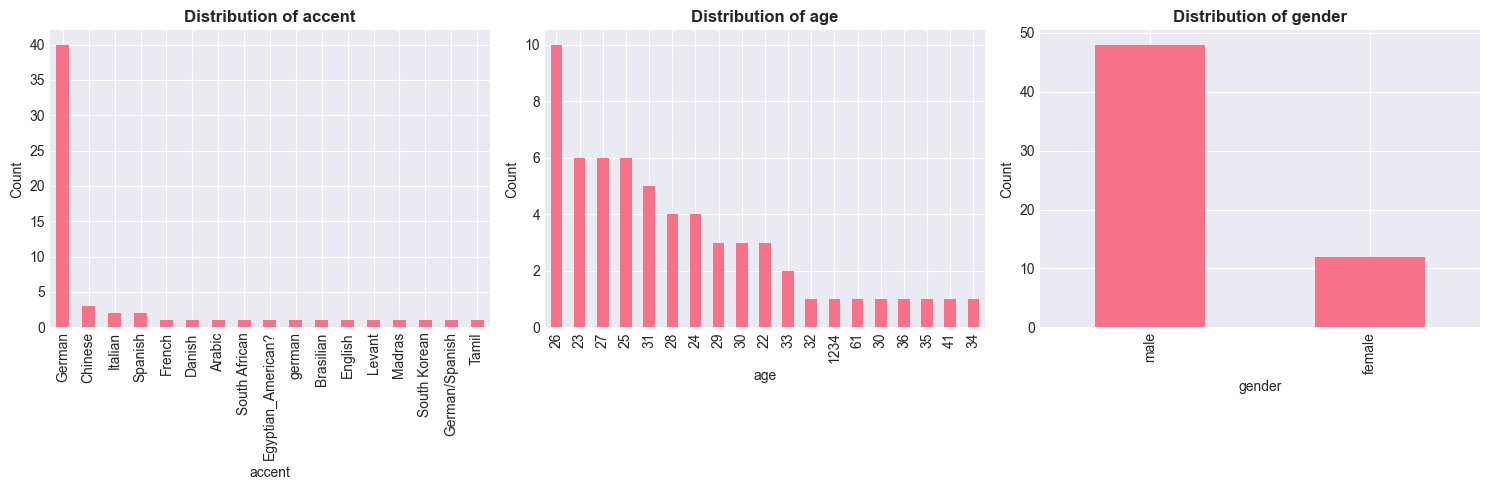

In [20]:
if df_meta is not None and len(df_meta.columns) > 1: #takes the "extra" metadata from metadata.py
    print("\n" + "=" * 50)
    print("METADATA ANALYSIS")
    print("=" * 50)
    
    # Show metadata summary
    print("\nMetadata Summary:")
    print(df_meta.head(10)) #this only shows the first 10 rows
    
    # If metadata has gender, age, or other categorical variables
    categorical_cols = df_meta.select_dtypes(include=['object']).columns 
    for col in categorical_cols: #for every category 
        if col != 'speaker_id' and col != 'recordingdate' and col != 'origin': #filter out the categories that we don't really care about
            print(f"\n{col.upper()} DISTRIBUTION:")
            print("-" * 40)
            value_counts = df_meta[col].value_counts()
            for value, count in value_counts.items():
                print(f"  {value:.<30} {count:>3}") #print the category headers and their corresponding values
            print(f"  {'Total unique values':.<30} {len(value_counts):>3}") #print total amount of values
    
    # Visualize metadata distributions
    categorical_cols = [col for col in categorical_cols if col != 'speaker_id' and col != 'recordingdate' and col != 'origin']
    if len(categorical_cols) > 0:
        n_cols = len(categorical_cols)
        fig, axes = plt.subplots(1, min(n_cols, 3), figsize=(15, 5))
        if n_cols == 1:
            axes = [axes]
        
        for idx, col in enumerate(categorical_cols[:3]):
            df_meta[col].value_counts().plot(kind='bar', ax=axes[idx])
            axes[idx].set_title(f'Distribution of {col}', fontweight='bold')
            axes[idx].set_xlabel(col)
            axes[idx].set_ylabel('Count')
        
        plt.tight_layout()
        plt.show()

In [4]:
myds = SoundDS(df, download_path) #create dataset with all the audio files and their paths

# Split data
num_items = len(myds)
num_train = round(num_items * 0.8) #reserve 80% of the data for training, and keep the other 20% for validating the model after training. 
num_val = num_items - num_train
train_ds, val_ds = random_split(myds, [num_train, num_val], 
                                 generator=torch.Generator().manual_seed(42)) #split the data randomly. This is something that I could look into and change, because there could be different ratios of training data depending on the speaker id

print(f"\nTraining samples: {num_train}")
print(f"Validation samples: {num_val}")

# Create data loaders
batch_size = 16 #this is how many files are loaded per batch
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=2) #load data, the training data must be shuffled so that the model doesn't have an order to start learning from
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=2) #this data does not need to be shuffled because we are just checking to see if our model works against this data

print(f"Training batches: {len(train_dl)}")
print(f"Validation batches: {len(val_dl)}")
print("=" * 50)


Training samples: 24000
Validation samples: 6000
Training batches: 1500
Validation batches: 375



SAMPLE DATA VISUALIZATION
Batch shape: torch.Size([16, 2, 64, 344])
Labels shape: torch.Size([16])


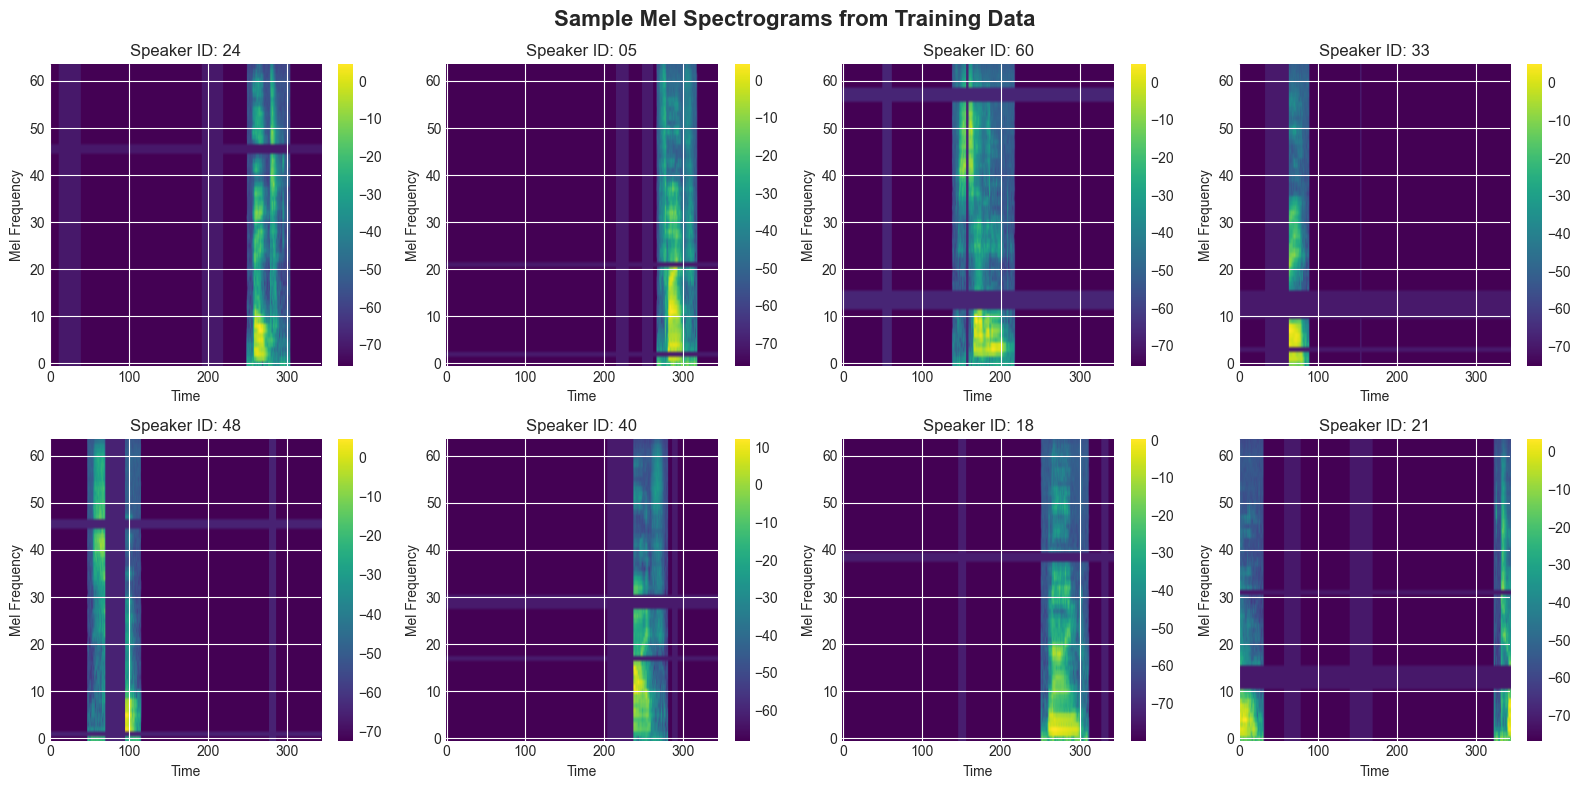

In [6]:
print("\n" + "=" * 50)
print("SAMPLE DATA VISUALIZATION")
print("=" * 50)

# Get a batch of training data
sample_inputs, sample_labels = next(iter(train_dl))
print(f"Batch shape: {sample_inputs.shape}")
print(f"Labels shape: {sample_labels.shape}")

# Visualize spectrograms from first batch
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
fig.suptitle('Sample Mel Spectrograms from Training Data', fontsize=16, fontweight='bold')

for idx, ax in enumerate(axes.flat):
    if idx < len(sample_inputs):
        # Take first channel of spectrogram
        spec = sample_inputs[idx][0].numpy()
        im = ax.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
        ax.set_title(f'Speaker ID: {sample_labels[idx].item() + 1:02d}')
        ax.set_xlabel('Time')
        ax.set_ylabel('Mel Frequency')
        plt.colorbar(im, ax=ax)

plt.tight_layout()
plt.show()

In [7]:
print("\n" + "=" * 50)
print("MODEL INITIALIZATION")
print("=" * 50)

model = AudioClassifier #create the model
model = model.to(device) #move the model to device, which in my case is my mac's integrated GPU (see GPU_CHOOSE.py)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model device: {next(model.parameters()).device}")
print("=" * 50)


MODEL INITIALIZATION
Total parameters: 28,852
Trainable parameters: 28,852
Model device: mps:0


In [9]:
criterion = nn.CrossEntropyLoss() #defines the loss function for the CNN, CEL is often used for multi-class classification. 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4) #Adam optimizer which updates the weights of each node during training. lr describes the rate of that each weight changes by, and the weight decay penalizes large weights to prevent overfitting
num_epochs = 20 #this defines the number of times that the model with train itself with the training data. The weight adjustments from previous epochs are kept in the new epochs, which is how the model learns

#This next part makes it so that the learning rate varies, starting lower than the max_lr, then halfway through increases to max_lr, and then decreases back down. 
scheduler = torch.optim.lr_scheduler.OneCycleLR( 
    optimizer, 
    max_lr=0.001,
    steps_per_epoch=len(train_dl),
    epochs=num_epochs
)

In [10]:
def train_epoch(model, train_loader, criterion, optimizer, scheduler, device):
    model.train() # Set model to training mode (enables dropout, batch norm updates, etc.)

    # Initialize variables for tracking performance across the epoch
    running_loss = 0.0 #Cumulative loss across all batches
    correct = 0 #number of correct predictions
    total = 0 #number of samples processed
    
    pbar = tqdm(train_loader, desc='Training') #progress bar to visualize training progress
    for inputs, labels in pbar: #loop through each batch in training data
        inputs, labels = inputs.to(device), labels.to(device) #move data to wherever the model is, in my case my mac's integrated GPU
        
        optimizer.zero_grad() #clears the gradient from the previous batch, without this it will acumulate
        outputs = model(inputs) #this is the forward pass, where we get the model's predictions 
        loss = criterion(outputs, labels) #calculate how wrong the model was, or the loss function
        loss.backward() #this is the backwards pass, where we calculate how we should adjust each weight to make the model's predictions more accurate, or to minimize the loss function. 
        optimizer.step() #this is where the weights are actually adjusted based on the calculated gradient 
        scheduler.step() #this now updates the learning rate according to OneCycleLR, explained in prior cell
        
        running_loss += loss.item() #updates the cumulative loss
        _, predicted = torch.max(outputs.data, 1) #get the predicted class, or the model's prediction
        total += labels.size(0) # update the total count, according to the number of samples in the batch
        correct += (predicted == labels).sum().item() #update the correct count, according to the number of correct predictions the model made in the batch
        
        pbar.set_postfix({'loss': f'{loss.item():.4f}', 
                         'acc': f'{100*correct/total:.2f}%'}) #update the progress bar
    
    epoch_loss = running_loss / len(train_loader) #average loss per batch
    epoch_acc = 100 * correct / total #overall accuracy of the epoch
    return epoch_loss, epoch_acc

def validate(model, val_loader, criterion, device): 
    model.eval() # Set model to evaluation mode (disables dropout, fixes batch norm, etc.)
    
    #variables to track stats, same as train function
    running_loss = 0.0 
    correct = 0
    total = 0

    with torch.no_grad(): #disables gradient calculation, which saves compute during validation
        pbar = tqdm(val_loader, desc='Validation') #progress bar similar to train function
        for inputs, labels in pbar: #iterate through each batch in the validation data
            inputs, labels = inputs.to(device), labels.to(device) #move data to GPU
            outputs = model(inputs) #forward pass
            loss = criterion(outputs, labels) #loss function
            
            running_loss += loss.item() #update cumulative loss variable
            _, predicted = torch.max(outputs.data, 1) #get the predicted class
            total += labels.size(0) #update total
            correct += (predicted == labels).sum().item() #update correct
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}',  #progress bar update
                             'acc': f'{100*correct/total:.2f}%'})
    
    epoch_loss = running_loss / len(val_loader) #average loss per batch
    epoch_acc = 100 * correct / total #overall accuracy of the epoch
    return epoch_loss, epoch_acc

In [11]:
print("\n" + "=" * 50)
print("TRAINING MODEL")
print("=" * 50)

#lists that track metrics across all epochs, used later for graphing and model analysis
train_losses = []
train_accs = []
val_losses = []
val_accs = []
best_val_acc = 0.0

for epoch in range(num_epochs): #cycle through the number of epochs, or basically run training the specified amount of times. 
    print(f'\nEpoch {epoch+1}/{num_epochs}')
    print('-' * 50)
    
    # Train
    train_loss, train_acc = train_epoch(model, train_dl, criterion, optimizer, scheduler, device) #runs a full pass through all the training data, updating the weights
    train_losses.append(train_loss) #store the metrics for the current epoch
    train_accs.append(train_acc)
    print(f'Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
    
    # Validate
    val_loss, val_acc = validate(model, val_dl, criterion, device) #evaluates the model based on the valuation data
    val_losses.append(val_loss) #store validation metrics for the current epoch
    val_accs.append(val_acc)
    print(f'Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')
    
    # Save best model
    if val_acc > best_val_acc: #if the current epoch's accuracy is the best so far, save that epoch's current model as the new best model. 
        best_val_acc = val_acc
        torch.save({
            'epoch': epoch, #which epoch
            'model_state_dict': model.state_dict(), #model's weights
            'optimizer_state_dict': optimizer.state_dict(), #optimizer state, saved if we want to train this model further
            'val_acc': val_acc, #model's current accuracy (best so far)
        }, 'best_speaker_model.pth')
        print(f'Saved new best model')

print(f'\n{"="*50}')
print(f'Training complete! Best validation accuracy: {best_val_acc:.2f}%')
print("=" * 50)


TRAINING MODEL

Epoch 1/20
--------------------------------------------------


Training: 100%|█████| 1500/1500 [00:59<00:00, 25.04it/s, loss=3.8360, acc=5.26%]


Train Loss: 3.8744, Train Acc: 5.26%


Validation: 100%|█████| 375/375 [00:22<00:00, 16.51it/s, loss=3.9072, acc=7.43%]


Val Loss: 3.6402, Val Acc: 7.43%
✓ Saved new best model!

Epoch 2/20
--------------------------------------------------


Training: 100%|█████| 1500/1500 [00:54<00:00, 27.77it/s, loss=3.4478, acc=7.86%]


Train Loss: 3.6326, Train Acc: 7.86%


Validation: 100%|████| 375/375 [00:22<00:00, 16.71it/s, loss=3.6775, acc=10.68%]


Val Loss: 3.5125, Val Acc: 10.68%
✓ Saved new best model!

Epoch 3/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:51<00:00, 29.07it/s, loss=3.2855, acc=11.40%]


Train Loss: 3.4906, Train Acc: 11.40%


Validation: 100%|████| 375/375 [00:21<00:00, 17.07it/s, loss=3.2503, acc=16.87%]


Val Loss: 3.2451, Val Acc: 16.87%
✓ Saved new best model!

Epoch 4/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:50<00:00, 29.43it/s, loss=2.9756, acc=17.70%]


Train Loss: 3.1559, Train Acc: 17.70%


Validation: 100%|████| 375/375 [00:21<00:00, 17.68it/s, loss=2.8257, acc=23.47%]


Val Loss: 2.8562, Val Acc: 23.47%
✓ Saved new best model!

Epoch 5/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.26it/s, loss=2.0789, acc=29.82%]


Train Loss: 2.6373, Train Acc: 29.82%


Validation: 100%|████| 375/375 [00:20<00:00, 17.88it/s, loss=2.0511, acc=44.12%]


Val Loss: 2.1503, Val Acc: 44.12%
✓ Saved new best model!

Epoch 6/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.10it/s, loss=1.8191, acc=47.37%]


Train Loss: 1.9781, Train Acc: 47.37%


Validation: 100%|████| 375/375 [00:21<00:00, 17.69it/s, loss=1.7101, acc=60.55%]


Val Loss: 1.5071, Val Acc: 60.55%
✓ Saved new best model!

Epoch 7/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.00it/s, loss=1.5307, acc=61.98%]


Train Loss: 1.4237, Train Acc: 61.98%


Validation: 100%|████| 375/375 [00:21<00:00, 17.78it/s, loss=0.9047, acc=69.93%]


Val Loss: 1.1228, Val Acc: 69.93%
✓ Saved new best model!

Epoch 8/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.07it/s, loss=1.3488, acc=71.26%]


Train Loss: 1.0710, Train Acc: 71.26%


Validation: 100%|████| 375/375 [00:21<00:00, 17.78it/s, loss=0.6887, acc=78.45%]


Val Loss: 0.8254, Val Acc: 78.45%
✓ Saved new best model!

Epoch 9/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.02it/s, loss=0.5638, acc=77.52%]


Train Loss: 0.8383, Train Acc: 77.52%


Validation: 100%|████| 375/375 [00:21<00:00, 17.79it/s, loss=0.9346, acc=80.87%]


Val Loss: 0.6923, Val Acc: 80.87%
✓ Saved new best model!

Epoch 10/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.33it/s, loss=1.1253, acc=81.36%]


Train Loss: 0.6931, Train Acc: 81.36%


Validation: 100%|████| 375/375 [00:20<00:00, 17.87it/s, loss=0.8045, acc=80.62%]


Val Loss: 0.6668, Val Acc: 80.62%

Epoch 11/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.03it/s, loss=0.8960, acc=83.20%]


Train Loss: 0.6137, Train Acc: 83.20%


Validation: 100%|████| 375/375 [00:21<00:00, 17.80it/s, loss=0.5308, acc=84.87%]


Val Loss: 0.5413, Val Acc: 84.87%
✓ Saved new best model!

Epoch 12/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.05it/s, loss=0.3910, acc=85.44%]


Train Loss: 0.5341, Train Acc: 85.44%


Validation: 100%|████| 375/375 [00:21<00:00, 17.82it/s, loss=0.6163, acc=86.23%]


Val Loss: 0.4918, Val Acc: 86.23%
✓ Saved new best model!

Epoch 13/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.35it/s, loss=0.2707, acc=87.08%]


Train Loss: 0.4731, Train Acc: 87.08%


Validation: 100%|████| 375/375 [00:20<00:00, 17.98it/s, loss=0.3012, acc=90.12%]


Val Loss: 0.3841, Val Acc: 90.12%
✓ Saved new best model!

Epoch 14/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.57it/s, loss=0.2706, acc=88.27%]


Train Loss: 0.4390, Train Acc: 88.27%


Validation: 100%|████| 375/375 [00:20<00:00, 17.91it/s, loss=0.4101, acc=90.13%]


Val Loss: 0.3587, Val Acc: 90.13%
✓ Saved new best model!

Epoch 15/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.57it/s, loss=0.2229, acc=88.99%]


Train Loss: 0.4071, Train Acc: 88.99%


Validation: 100%|████| 375/375 [00:20<00:00, 17.92it/s, loss=0.2870, acc=92.13%]


Val Loss: 0.3005, Val Acc: 92.13%
✓ Saved new best model!

Epoch 16/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.51it/s, loss=0.6790, acc=89.60%]


Train Loss: 0.3866, Train Acc: 89.60%


Validation: 100%|████| 375/375 [00:20<00:00, 17.91it/s, loss=0.2315, acc=92.37%]


Val Loss: 0.2944, Val Acc: 92.37%
✓ Saved new best model!

Epoch 17/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.51it/s, loss=0.6921, acc=89.93%]


Train Loss: 0.3702, Train Acc: 89.93%


Validation: 100%|████| 375/375 [00:20<00:00, 17.87it/s, loss=0.1779, acc=92.77%]


Val Loss: 0.2731, Val Acc: 92.77%
✓ Saved new best model!

Epoch 18/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.30it/s, loss=0.2287, acc=90.04%]


Train Loss: 0.3638, Train Acc: 90.04%


Validation: 100%|████| 375/375 [00:21<00:00, 17.84it/s, loss=0.2503, acc=92.85%]


Val Loss: 0.2763, Val Acc: 92.85%
✓ Saved new best model!

Epoch 19/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [00:49<00:00, 30.15it/s, loss=0.3351, acc=90.35%]


Train Loss: 0.3571, Train Acc: 90.35%


Validation: 100%|████| 375/375 [00:21<00:00, 17.81it/s, loss=0.1399, acc=93.17%]


Val Loss: 0.2624, Val Acc: 93.17%
✓ Saved new best model!

Epoch 20/20
--------------------------------------------------


Training: 100%|████| 1500/1500 [14:14<00:00,  1.76it/s, loss=0.5861, acc=90.53%]


Train Loss: 0.3551, Train Acc: 90.53%


Validation: 100%|████| 375/375 [00:20<00:00, 18.11it/s, loss=0.2033, acc=92.95%]

Val Loss: 0.2779, Val Acc: 92.95%

Training complete! Best validation accuracy: 93.17%


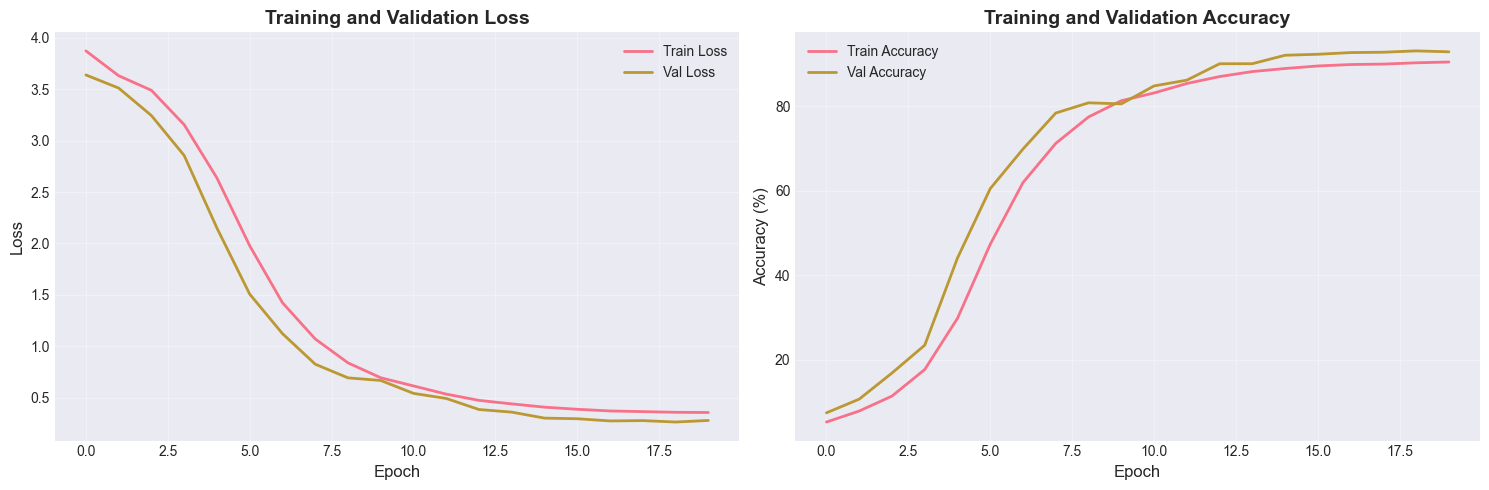

In [12]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
ax1.plot(train_losses, label='Train Loss', linewidth=2)
ax1.plot(val_losses, label='Val Loss', linewidth=2)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('Training and Validation Loss', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy plot
ax2.plot(train_accs, label='Train Accuracy', linewidth=2)
ax2.plot(val_accs, label='Val Accuracy', linewidth=2)
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('Training and Validation Accuracy', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [13]:
print("\n" + "=" * 50)
print("LOADING BEST MODEL FOR EVALUATION")
print("=" * 50)

# Load best model
checkpoint = torch.load('best_speaker_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"Loaded model from epoch {checkpoint['epoch']+1}")
print(f"Best validation accuracy: {checkpoint['val_acc']:.2f}%")

# Get predictions for confusion matrix
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in tqdm(val_dl, desc='Getting predictions'):
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


LOADING BEST MODEL FOR EVALUATION
Loaded model from epoch 19
Best validation accuracy: 93.17%


Getting predictions: 100%|████████████████████| 375/375 [00:19<00:00, 18.75it/s]



CONFUSION MATRIX


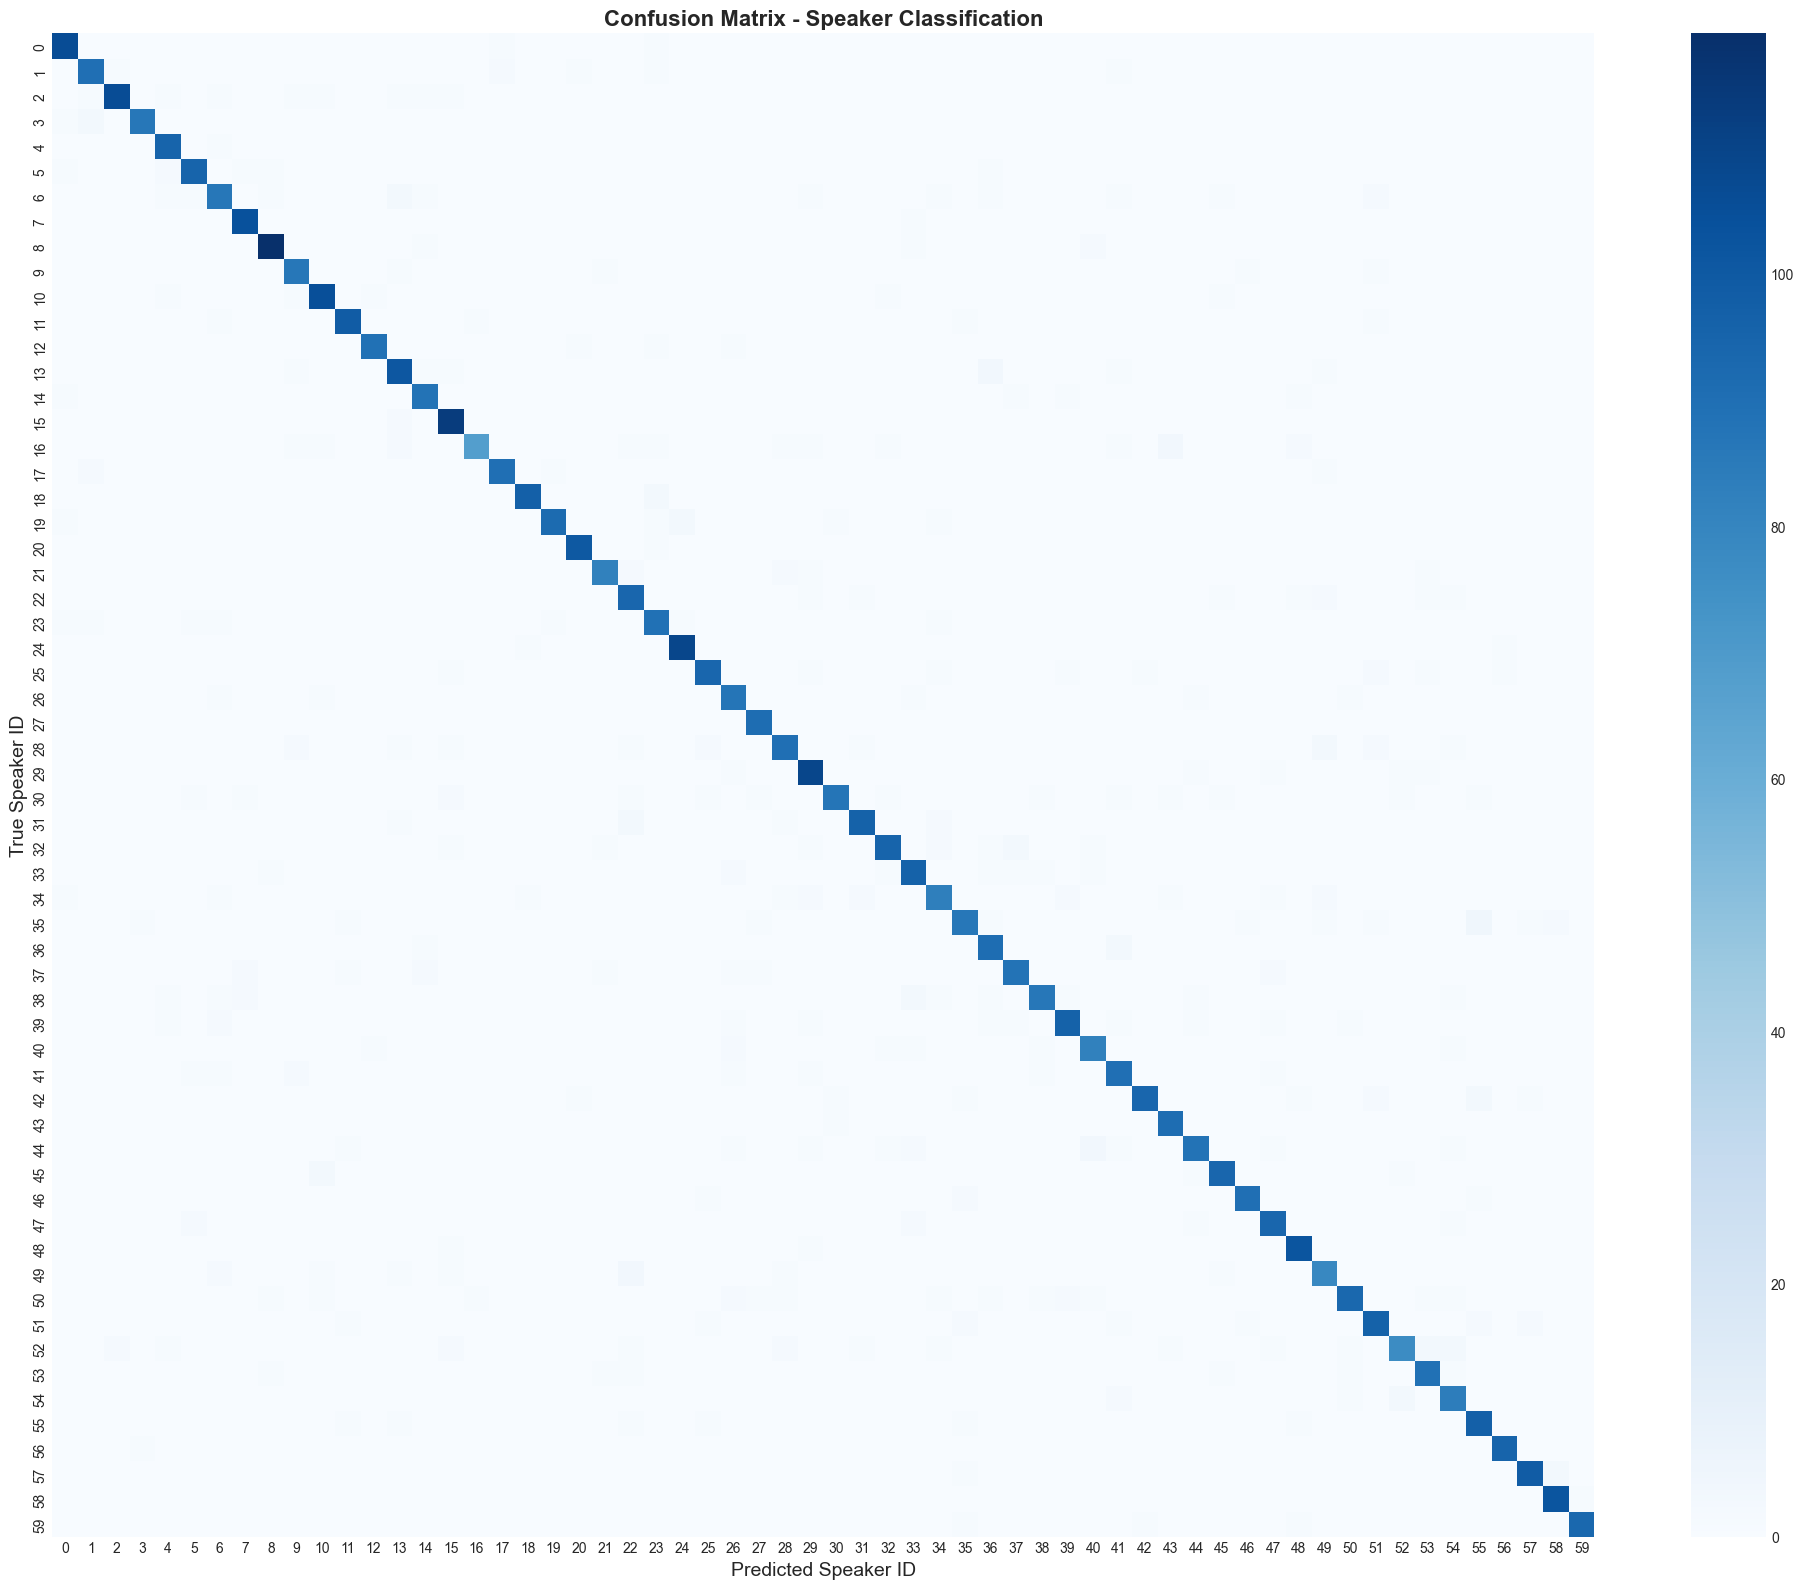


Per-Speaker Accuracy:
Speaker 01: 98.1%
Speaker 02: 93.8%
Speaker 03: 93.0%
Speaker 04: 95.6%
Speaker 05: 99.0%
Speaker 06: 94.1%
Speaker 07: 86.0%
Speaker 08: 99.0%
Speaker 09: 96.7%
Speaker 10: 95.6%
Speaker 11: 95.5%
Speaker 12: 96.1%
Speaker 13: 96.7%
Speaker 14: 91.8%
Speaker 15: 95.7%
Speaker 16: 98.3%
Speaker 17: 81.0%
Speaker 18: 95.7%
Speaker 19: 97.0%
Speaker 20: 92.9%
Speaker 21: 99.0%
Speaker 22: 93.2%
Speaker 23: 92.2%
Speaker 24: 92.7%
Speaker 25: 98.2%
Speaker 26: 91.3%
Speaker 27: 94.6%
Speaker 28: 100.0%
Speaker 29: 86.5%
Speaker 30: 95.6%
Speaker 31: 86.1%
Speaker 32: 93.2%
Speaker 33: 90.5%
Speaker 34: 92.3%
Speaker 35: 85.6%
Speaker 36: 85.1%
Speaker 37: 95.8%
Speaker 38: 89.8%
Speaker 39: 87.8%
Speaker 40: 89.7%
Speaker 41: 92.1%
Speaker 42: 91.8%
Speaker 43: 90.4%
Speaker 44: 98.9%
Speaker 45: 87.1%
Speaker 46: 94.9%
Speaker 47: 95.7%
Speaker 48: 94.0%
Speaker 49: 98.1%
Speaker 50: 87.8%
Speaker 51: 86.1%
Speaker 52: 90.6%
Speaker 53: 80.2%
Speaker 54: 93.7%
Spea

In [14]:
print("\n" + "=" * 50)
print("CONFUSION MATRIX")
print("=" * 50)

cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(20, 16))
sns.heatmap(cm, annot=False, fmt='d', cmap='Blues', cbar=True)
plt.title('Confusion Matrix - Speaker Classification', fontsize=16, fontweight='bold')
plt.ylabel('True Speaker ID', fontsize=14)
plt.xlabel('Predicted Speaker ID', fontsize=14)
plt.tight_layout()
plt.show()

# Print per-class accuracy
class_accuracy = cm.diagonal() / cm.sum(axis=1)
print("\nPer-Speaker Accuracy:")
for i, acc in enumerate(class_accuracy):
    print(f"Speaker {i+1:02d}: {acc*100:.1f}%")
print(f"\nMean Accuracy: {class_accuracy.mean()*100:.2f}%")


DETAILED CLASSIFICATION REPORT
              precision    recall  f1-score   support

  Speaker_01       0.95      0.98      0.96       108
  Speaker_02       0.93      0.94      0.93        96
  Speaker_03       0.97      0.93      0.95       114
  Speaker_04       0.98      0.96      0.97        90
  Speaker_05       0.92      0.99      0.95        96
  Speaker_06       0.94      0.94      0.94       101
  Speaker_07       0.88      0.86      0.87       100
  Speaker_08       0.95      0.99      0.97       105
  Speaker_09       0.96      0.97      0.96       123
  Speaker_10       0.91      0.96      0.93        90
  Speaker_11       0.93      0.95      0.94       110
  Speaker_12       0.95      0.96      0.96       103
  Speaker_13       0.98      0.97      0.97        92
  Speaker_14       0.89      0.92      0.90       110
  Speaker_15       0.93      0.96      0.94        92
  Speaker_16       0.91      0.98      0.95       115
  Speaker_17       0.97      0.81      0.88      

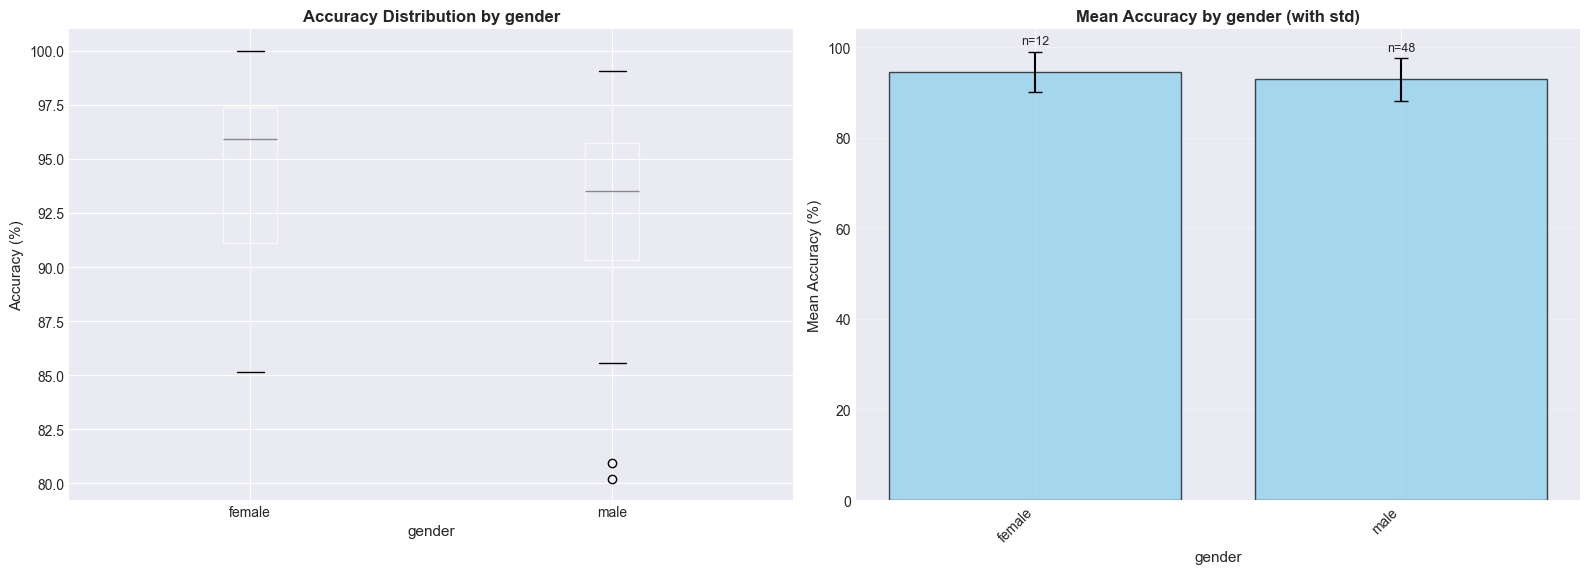


ACCURACY BY NATIVE SPEAKER

Summary Statistics:
                    mean       std  count
native speaker                           
yes             95.33661  2.773526      3
no              93.06322  4.691180     57


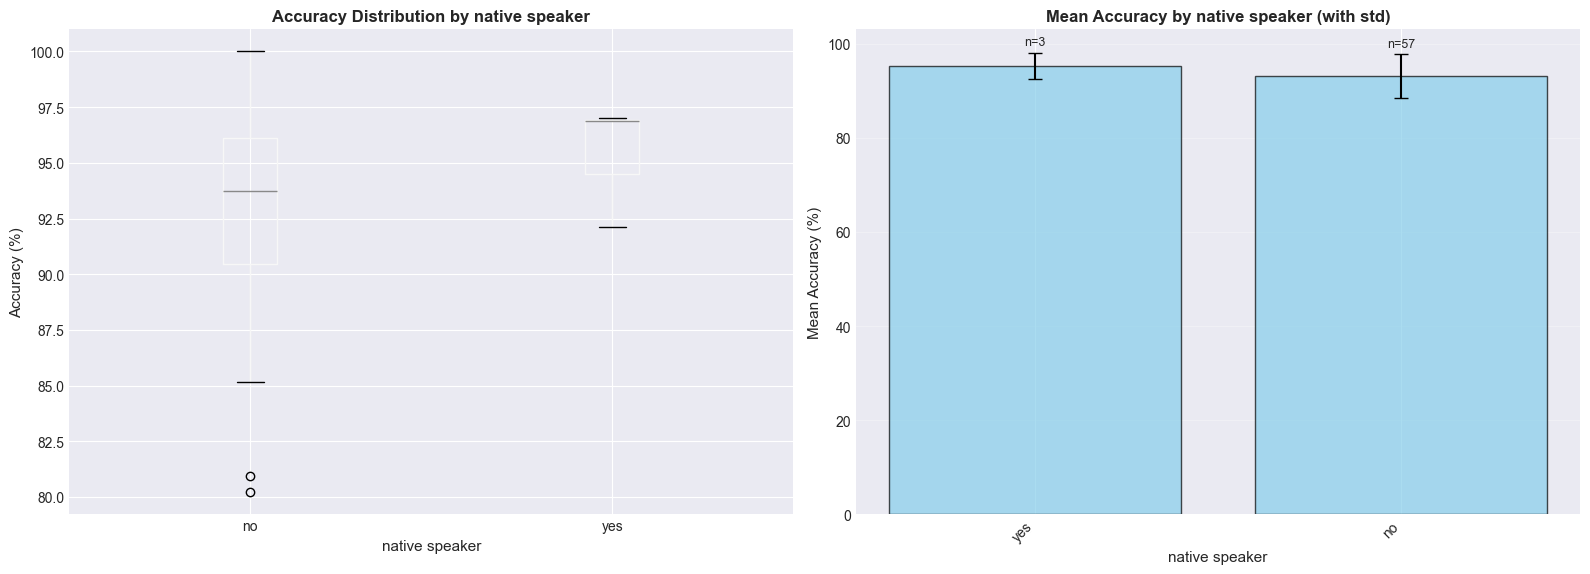


Skipping origin (too many categories: 42)

Skipping recordingdate (too many categories: 60)

ACCURACY BY RECORDINGROOM

Summary Statistics:
                    mean       std  count
recordingroom                            
library        95.275784  4.412057      3
Ruheraum       95.040337  3.440061      3
VR-Room        94.669357  2.799010      4
Kino           94.660185  4.462867     19
vr-room        91.876268  4.868024     28
vr-romm        90.566038       NaN      1
VR-room        89.671249  4.995900      2


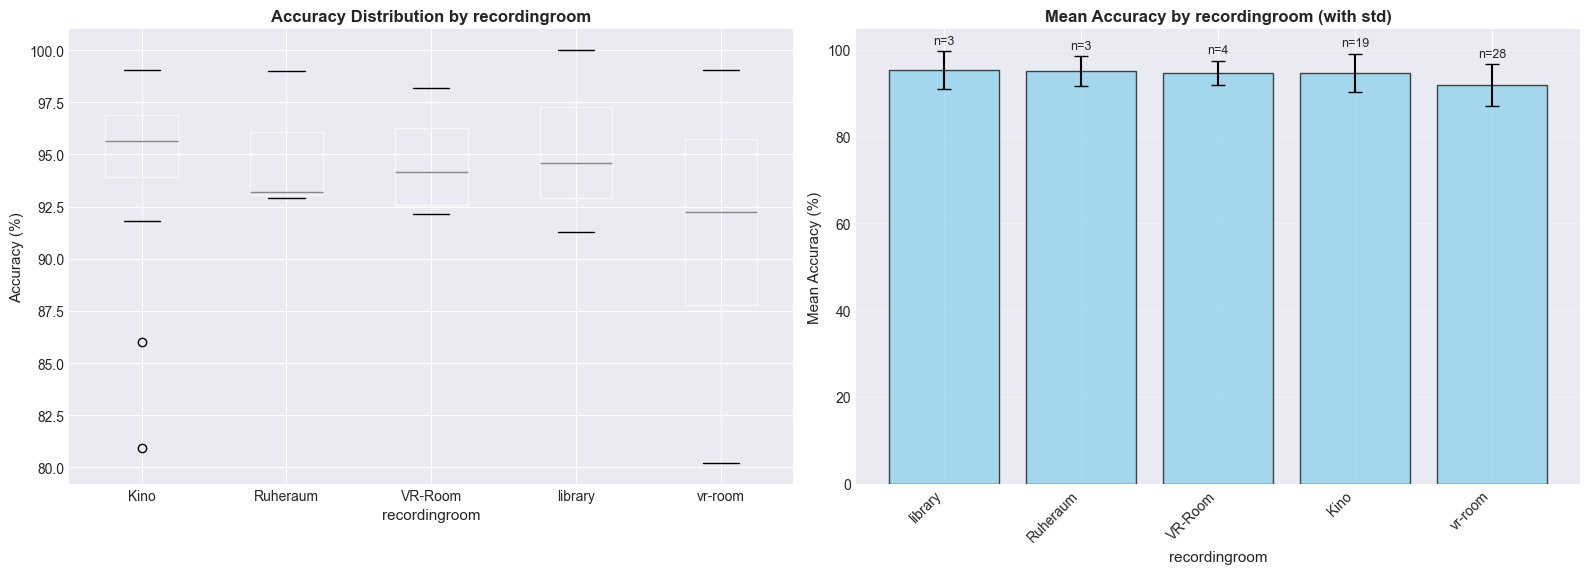


ACCURACY BY AGE

Summary Statistics by Age Group:
                mean       std  count
age_group                            
18-25      92.182213  4.964769     19
26-35      93.473145  4.369027     37
36-45      97.301587  2.469262      2
46+        98.913043       NaN      1


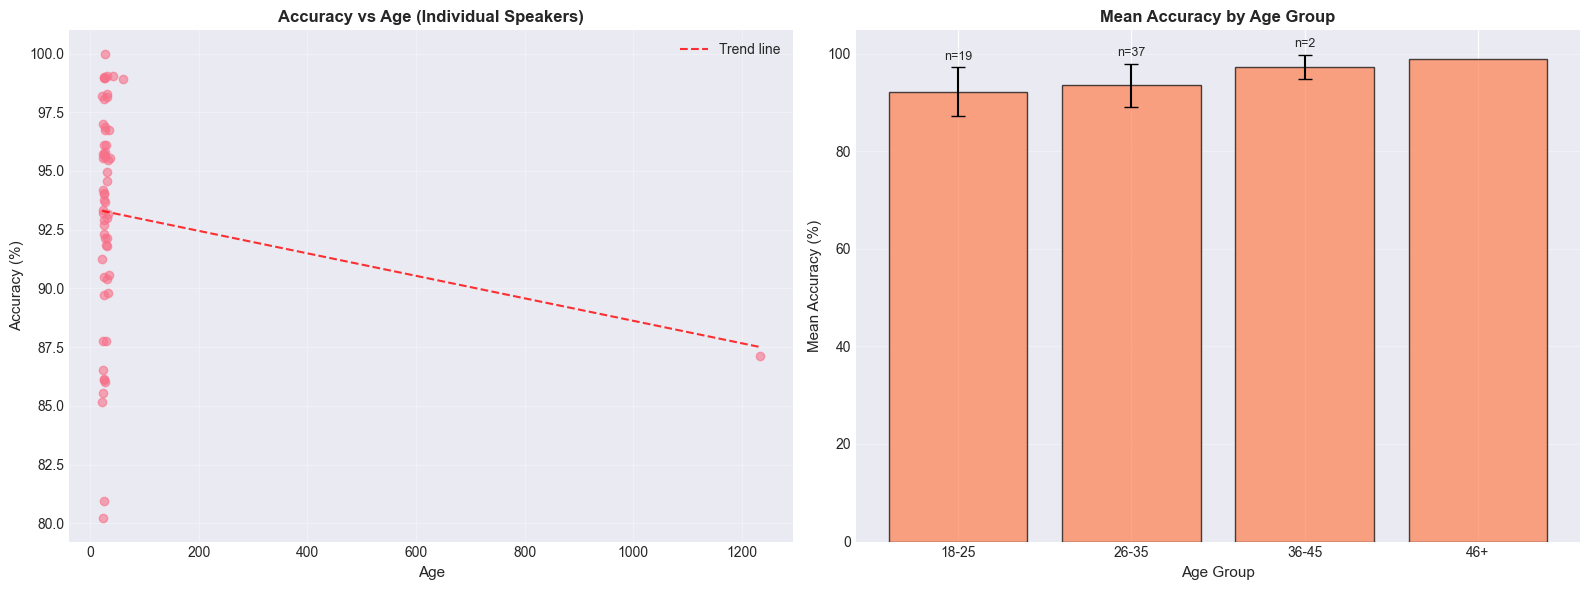

In [19]:
print("\n" + "=" * 50)
print("DETAILED CLASSIFICATION REPORT")
print("=" * 50)

# Show report for subset of speakers (to keep it readable)
target_names = [f"Speaker_{i+1:02d}" for i in range(60)]
print(classification_report(all_labels, all_preds, target_names=target_names))

if df_meta is not None and len(df_meta.columns) > 1:
    print("\n" + "=" * 50)
    print("PERFORMANCE BY DEMOGRAPHIC GROUPS")
    print("=" * 50)
    
    # Get predictions per speaker
    speaker_accuracy = {}
    for speaker_id in range(60):
        mask = all_labels == speaker_id
        if mask.sum() > 0:
            correct = (all_preds[mask] == speaker_id).sum()
            total = mask.sum()
            speaker_accuracy[f"{speaker_id+1:02d}"] = correct / total * 100
    
    # Create dataframe with accuracy
    accuracy_df = pd.DataFrame.from_dict(speaker_accuracy, orient='index', columns=['Accuracy'])
    accuracy_df.index.name = 'speaker_id'
    accuracy_df.reset_index(inplace=True)
    
    # Merge with metadata
    analysis_df = accuracy_df.merge(df_meta, on='speaker_id', how='left')
    
    # Analyze by categorical variables
    categorical_cols = df_meta.select_dtypes(include=['object']).columns
    categorical_cols = [col for col in categorical_cols if col != 'speaker_id']
    
    # Also check for numeric columns that might be age
    numeric_cols = df_meta.select_dtypes(include=['int64', 'float64']).columns
    
    for col in categorical_cols:
        if col in analysis_df.columns:
            # Skip if too many unique values (like individual accents with only 1 speaker each)
            n_unique = analysis_df[col].nunique()
            if n_unique > 15:
                print(f"\nSkipping {col} (too many categories: {n_unique})")
                continue
                
            print(f"\n{'='*50}")
            print(f"ACCURACY BY {col.upper()}")
            print('='*50)
            
            grouped = analysis_df.groupby(col)['Accuracy'].agg(['mean', 'std', 'count'])
            grouped = grouped.sort_values('mean', ascending=False)
            
            print("\nSummary Statistics:")
            print(grouped.to_string())
            
            # Only plot if there are enough samples per category
            if len(grouped) > 1 and len(grouped) <= 10:
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
                
                # Box plot
                categories_with_data = analysis_df[col].value_counts()
                categories_to_plot = categories_with_data[categories_with_data >= 3].index
                plot_df = analysis_df[analysis_df[col].isin(categories_to_plot)]
                
                if len(plot_df) > 0:
                    plot_df.boxplot(column='Accuracy', by=col, ax=ax1)
                    ax1.set_title(f'Accuracy Distribution by {col}', fontweight='bold', fontsize=12)
                    ax1.set_xlabel(col, fontsize=11)
                    ax1.set_ylabel('Accuracy (%)', fontsize=11)
                    plt.suptitle('')
                    
                    # Bar plot with error bars
                    grouped_plot = plot_df.groupby(col)['Accuracy'].agg(['mean', 'std', 'count'])
                    grouped_plot = grouped_plot.sort_values('mean', ascending=False)
                    
                    ax2.bar(range(len(grouped_plot)), grouped_plot['mean'], 
                           yerr=grouped_plot['std'], capsize=5, alpha=0.7, color='skyblue', edgecolor='black')
                    ax2.set_xticks(range(len(grouped_plot)))
                    ax2.set_xticklabels(grouped_plot.index, rotation=45, ha='right')
                    ax2.set_ylabel('Mean Accuracy (%)', fontsize=11)
                    ax2.set_xlabel(col, fontsize=11)
                    ax2.set_title(f'Mean Accuracy by {col} (with std)', fontweight='bold', fontsize=12)
                    ax2.grid(axis='y', alpha=0.3)
                    
                    # Add sample size labels
                    for i, (idx, row) in enumerate(grouped_plot.iterrows()):
                        ax2.text(i, row['mean'] + row['std'] + 1, f"n={int(row['count'])}", 
                                ha='center', va='bottom', fontsize=9)
                    
                    plt.tight_layout()
                    plt.show()
    
    # Handle age separately if it exists (to sort chronologically)
    age_cols = [col for col in numeric_cols if 'age' in col.lower()]
    if not age_cols:
        age_cols = [col for col in categorical_cols if 'age' in col.lower()]
    
    for age_col in age_cols:
        if age_col in analysis_df.columns:
            print(f"\n{'='*50}")
            print(f"ACCURACY BY {age_col.upper()}")
            print('='*50)
            
            # Try to convert to numeric if it's categorical
            try:
                analysis_df[f'{age_col}_numeric'] = pd.to_numeric(analysis_df[age_col], errors='coerce')
                age_data = analysis_df.dropna(subset=[f'{age_col}_numeric'])
                
                if len(age_data) > 0:
                    # Group by age ranges
                    age_data['age_group'] = pd.cut(age_data[f'{age_col}_numeric'], 
                                                    bins=[0, 25, 35, 45, 100],
                                                    labels=['18-25', '26-35', '36-45', '46+'])
                    
                    grouped = age_data.groupby('age_group', observed=True)['Accuracy'].agg(['mean', 'std', 'count'])
                    print("\nSummary Statistics by Age Group:")
                    print(grouped.to_string())
                    
                    # Plot
                    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
                    
                    # Scatter plot
                    ax1.scatter(age_data[f'{age_col}_numeric'], age_data['Accuracy'], alpha=0.6)
                    ax1.set_xlabel('Age', fontsize=11)
                    ax1.set_ylabel('Accuracy (%)', fontsize=11)
                    ax1.set_title('Accuracy vs Age (Individual Speakers)', fontweight='bold', fontsize=12)
                    ax1.grid(True, alpha=0.3)
                    
                    # Add trend line
                    z = np.polyfit(age_data[f'{age_col}_numeric'], age_data['Accuracy'], 1)
                    p = np.poly1d(z)
                    ax1.plot(sorted(age_data[f'{age_col}_numeric']), 
                            p(sorted(age_data[f'{age_col}_numeric'])), 
                            "r--", alpha=0.8, label=f'Trend line')
                    ax1.legend()
                    
                    # Bar plot by age group
                    ax2.bar(range(len(grouped)), grouped['mean'], 
                           yerr=grouped['std'], capsize=5, alpha=0.7, color='coral', edgecolor='black')
                    ax2.set_xticks(range(len(grouped)))
                    ax2.set_xticklabels(grouped.index, rotation=0)
                    ax2.set_ylabel('Mean Accuracy (%)', fontsize=11)
                    ax2.set_xlabel('Age Group', fontsize=11)
                    ax2.set_title('Mean Accuracy by Age Group', fontweight='bold', fontsize=12)
                    ax2.grid(axis='y', alpha=0.3)
                    
                    # Add sample size labels
                    for i, (idx, row) in enumerate(grouped.iterrows()):
                        ax2.text(i, row['mean'] + row['std'] + 1, f"n={int(row['count'])}", 
                                ha='center', va='bottom', fontsize=9)
                    
                    plt.tight_layout()
                    plt.show()
            except:
                # If age is categorical and can't be converted, treat it normally
                grouped = analysis_df.groupby(age_col)['Accuracy'].agg(['mean', 'std', 'count'])
                print("\nSummary Statistics:")
                print(grouped.to_string())


TESTING ON INDIVIDUAL SAMPLES


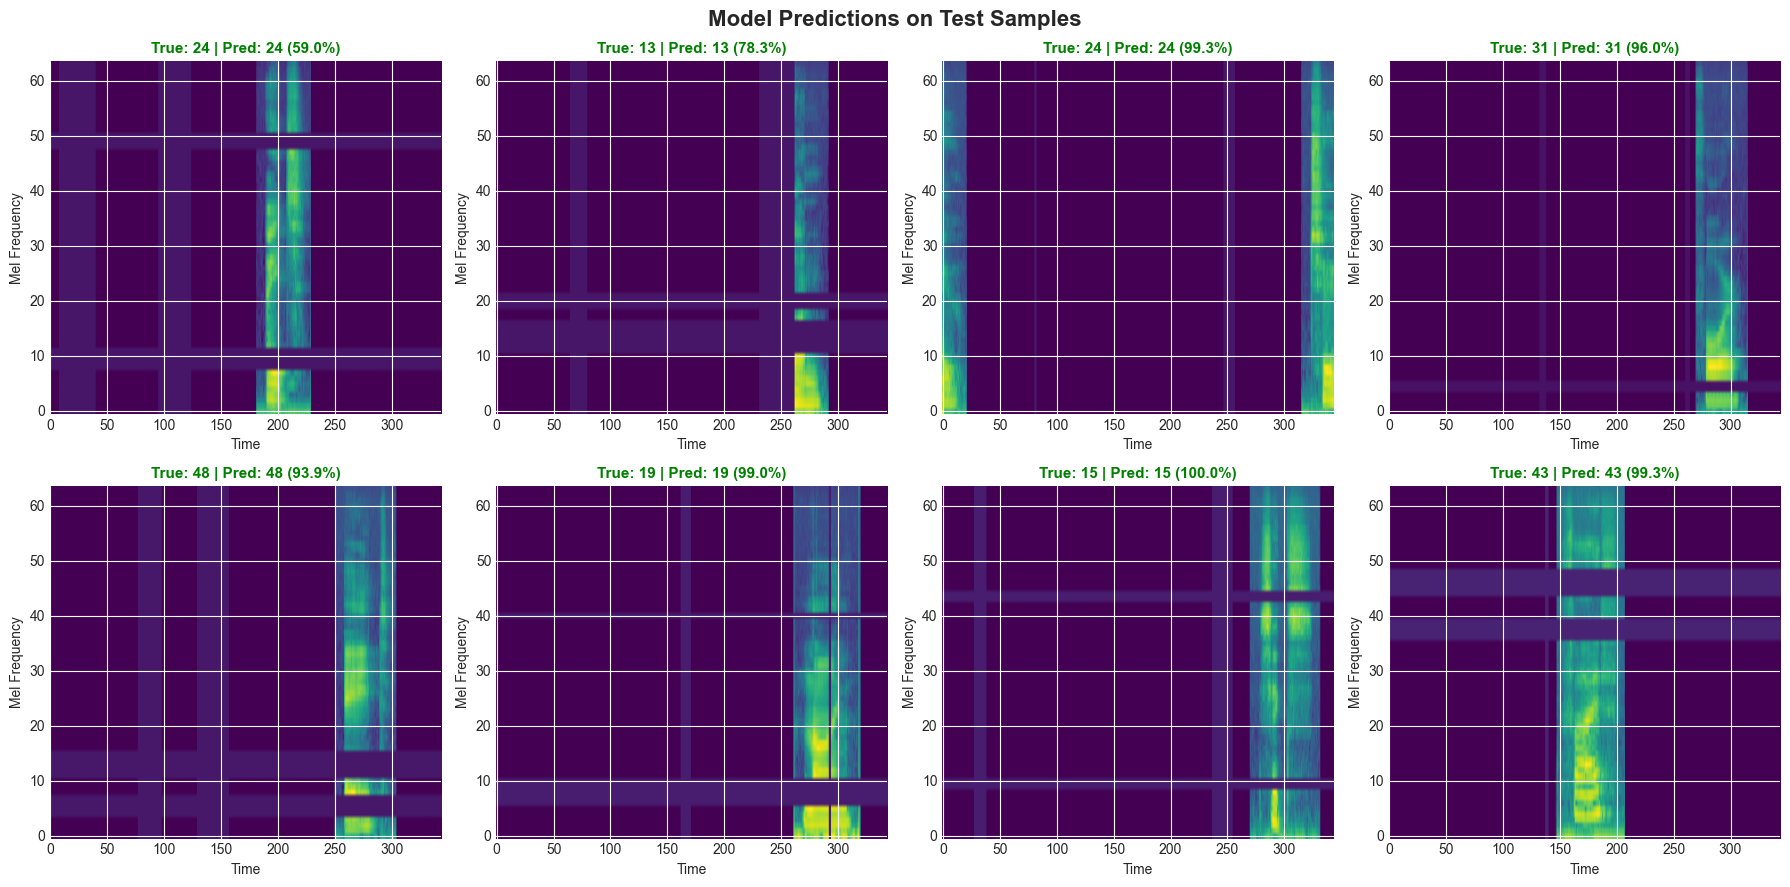

In [16]:
print("\n" + "=" * 50)
print("TESTING ON INDIVIDUAL SAMPLES")
print("=" * 50)

# Get a few samples from validation set
test_samples = 8
sample_inputs, sample_labels = next(iter(val_dl))

fig, axes = plt.subplots(2, 4, figsize=(18, 9))
fig.suptitle('Model Predictions on Test Samples', fontsize=16, fontweight='bold')

model.eval()
with torch.no_grad():
    sample_inputs_device = sample_inputs[:test_samples].to(device)
    outputs = model(sample_inputs_device)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predicted = torch.max(outputs, 1)

for idx, ax in enumerate(axes.flat):
    # Show spectrogram
    spec = sample_inputs[idx][0].numpy()
    im = ax.imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    
    true_label = sample_labels[idx].item()
    pred_label = predicted[idx].item()
    confidence = probabilities[idx][pred_label].item() * 100
    
    # Color code: green if correct, red if wrong
    color = 'green' if true_label == pred_label else 'red'
    
    ax.set_title(f'True: {true_label+1:02d} | Pred: {pred_label+1:02d} ({confidence:.1f}%)',
                fontweight='bold', color=color, fontsize=11)
    ax.set_xlabel('Time')
    ax.set_ylabel('Mel Frequency')

plt.tight_layout()
plt.show()


TOP-5 PREDICTIONS FOR SAMPLE

True Speaker: 24

Top 5 Predictions:
1. Speaker 24: 58.96%
2. Speaker 19: 14.70%
3. Speaker 13: 9.65%
4. Speaker 06: 3.88%
5. Speaker 25: 2.52%


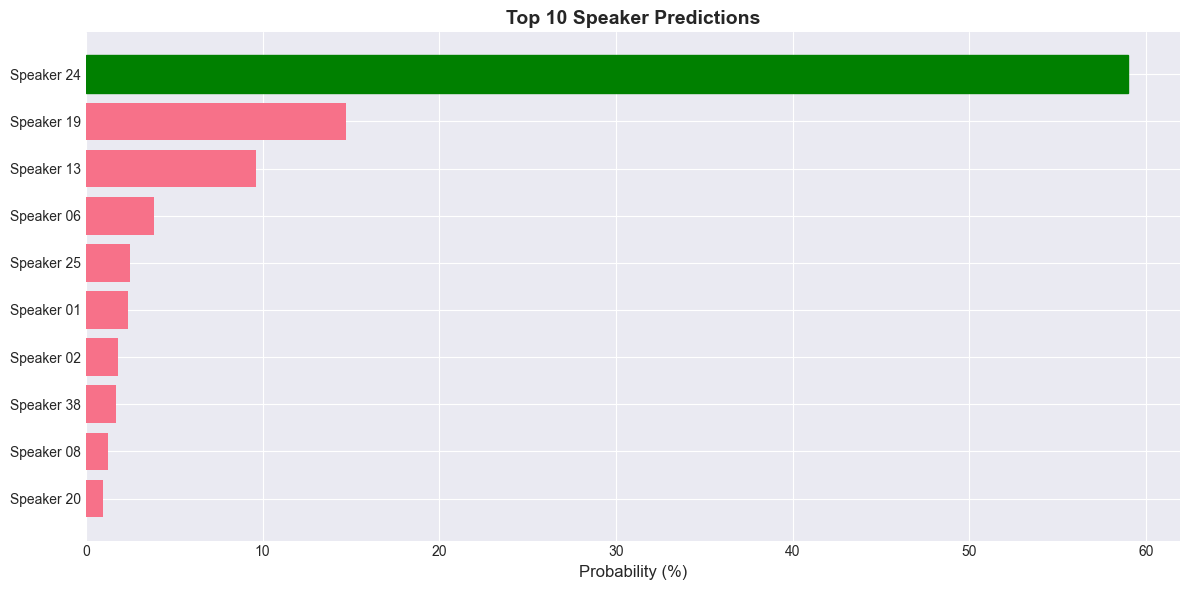


EVALUATION COMPLETE!


In [17]:
print("\n" + "=" * 50)
print("TOP-5 PREDICTIONS FOR SAMPLE")
print("=" * 50)

# Show detailed predictions for first sample
sample_idx = 0
sample_probs = probabilities[sample_idx].cpu().numpy()
top5_indices = np.argsort(sample_probs)[-5:][::-1]

print(f"\nTrue Speaker: {sample_labels[sample_idx].item() + 1:02d}")
print("\nTop 5 Predictions:")
for rank, idx in enumerate(top5_indices, 1):
    print(f"{rank}. Speaker {idx+1:02d}: {sample_probs[idx]*100:.2f}%")

# Visualize top predictions
fig, ax = plt.subplots(figsize=(12, 6))
top10_indices = np.argsort(sample_probs)[-10:][::-1]
top10_probs = sample_probs[top10_indices] * 100
top10_labels = [f"Speaker {i+1:02d}" for i in top10_indices]

bars = ax.barh(top10_labels, top10_probs)
# Color the true label green
true_label_pos = list(top10_indices).index(sample_labels[sample_idx].item()) if sample_labels[sample_idx].item() in top10_indices else -1
if true_label_pos >= 0:
    bars[true_label_pos].set_color('green')

ax.set_xlabel('Probability (%)', fontsize=12)
ax.set_title('Top 10 Speaker Predictions', fontsize=14, fontweight='bold')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print("\n" + "=" * 50)
print("EVALUATION COMPLETE!")
print("=" * 50)